In [1]:
import pandas as pd
import numpy as np
import torch as pt
from scipy.linalg import qr
import matplotlib.pyplot as plt
%matplotlib inline

from ml_lib.clusters.root_cluster import RootCluster as Root
from ml_lib.clusters.data_cluster import DataCluster as Data
from ml_lib.clusters.dense_cluster import DenseCluster as Dense
from ml_lib.controllers.controller import Controller as Control

from ml_lib.utils import *

#pt.set_default_tensor_type('torch.FloatTensor')
pt.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
dataset = pd.read_csv(
    'data_files/kc_house_data.csv',
    index_col = 'id', parse_dates = ['date'], date_parser = lambda x: pd.datetime.strptime(x, '%Y%m%dT%H%M%S')
)
dataset = dataset[[col for col in dataset.columns if not col.endswith('15')]]

In [3]:
feature_cols = ['sqft_living', 'bedrooms', 'bathrooms']
target_cols = ['price']

learner = learners.ADAM
learn_params = {
    'learn_rate': 1e-1,
    'window_rate': 0.1,
    'sq_window_rate': 0.001,
    'scale_features': True,
    'noise_rate': 1e-5,
    'noise_coef': 0.55
}

init = inits.Orthogonal
init_params = {
    'xavier': True
}

activator = activators.ReLU
activator_params = {}

control = Control(valid_split = 'holdout')
control.add_cluster(
    Data(
        'data_cluster',
        dataset[feature_cols + target_cols],
        splitter = splitters.Holdout, splitter_params = {},
        loss = losses.Huber, loss_params = {'steepness': 1}
    )
)
control.add_link(
    Dense(
        'reg_cluster_1',
        512,
        weight_init = init, weight_init_params = init_params,
        activator = activator, activator_params = activator_params,
        learner = learner, learner_params = learn_params
    ),
    'data_cluster', 'input', data_cols = feature_cols
)
control.add_link(
    Dense(
        'reg_cluster_2',
        128,
        weight_init = init, weight_init_params = init_params,
        activator = activator, activator_params = activator_params,
        learner = learner, learner_params = learn_params
    ),
    'reg_cluster_1', 'input'
)
control.add_link(
    Dense(
        'reg_cluster_3',
        32,
        weight_init = init, weight_init_params = init_params,
        activator = activator, activator_params = activator_params,
        learner = learner, learner_params = learn_params
    ),
    'reg_cluster_2', 'input'
)
control.add_link(
    Dense(
        'reg_cluster_out',
        len(target_cols),
        weight_init = init, weight_init_params = init_params,
        learner = learner, learner_params = learn_params
    ),
    'reg_cluster_3', 'input'
)
control.link_clusters('reg_cluster_out', 'data_cluster', data_cols = target_cols)
control.init_clusters()

In [4]:
control.train_model(500)

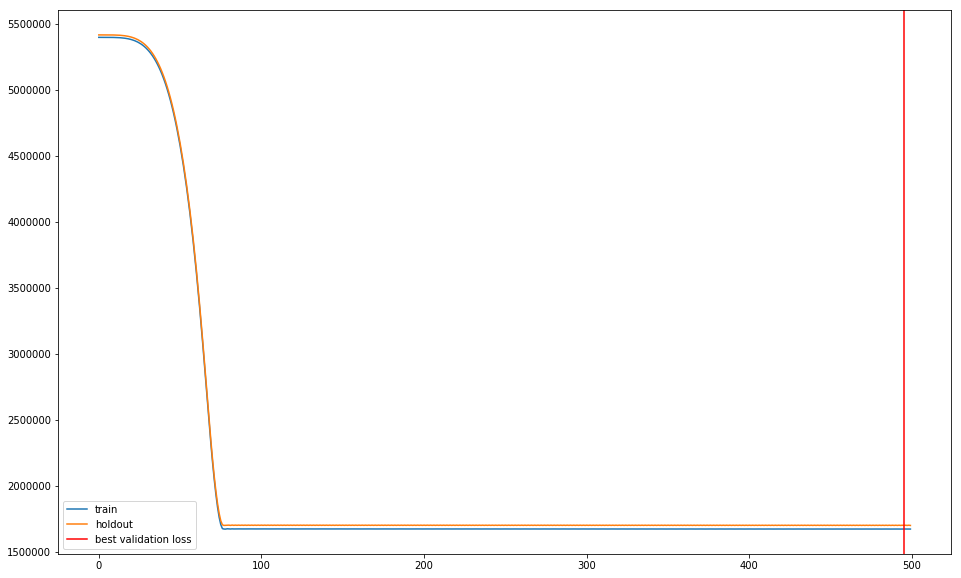

In [5]:
control.plot_losses()